<a href="https://colab.research.google.com/github/BrunoSan123/ML-works/blob/main/Projeto_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import zipfile
import random
import tensorflow as tf
import keras
#keras.optimizers.RMSprop(learning_rate=0.1)
#keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

from shutil import copyfile

In [2]:
import requests  # Import requests for better download handling

# Download the file using requests to handle potential download errors
url = "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip"
local_zip = '/tmp/cats-and-dogs.zip'

try:
    response = requests.get(url, stream=True)
    response.raise_for_status()  # Raise an exception for bad status codes (e.g., 404)
    with open(local_zip, 'wb') as file:
        for chunk in response.iter_content(chunk_size=8192):
            file.write(chunk)
    print("File downloaded successfully.")
except requests.exceptions.RequestException as e:
    print(f"Error downloading file: {e}")

# Now try opening the zip file
try:
    zip_ref = zipfile.ZipFile(local_zip, 'r')
    zip_ref.extractall('/tmp')
    zip_ref.close()
    print("File extracted successfully.")
except zipfile.BadZipFile:
    print("Downloaded file is not a valid zip file. Please check the URL or download again.")
except Exception as e:
    print(f"An error occurred: {e}")

File downloaded successfully.
File extracted successfully.


In [3]:
print(len(os.listdir('/tmp/PetImages/Cat/')))
print(len(os.listdir('/tmp/PetImages/Dog/')))

12501
12501


In [4]:
try:
    os.mkdir('/tmp/cats-v-dogs')
    os.mkdir('/tmp/cats-v-dogs/training')
    os.mkdir('/tmp/cats-v-dogs/testing')
    os.mkdir('/tmp/cats-v-dogs/training/cats')
    os.mkdir('/tmp/cats-v-dogs/training/dogs')
    os.mkdir('/tmp/cats-v-dogs/testing/cats')
    os.mkdir('/tmp/cats-v-dogs/testing/dogs')
except OSError:
    pass

In [5]:
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
    files = []
    for filename in os.listdir(SOURCE):
        file = SOURCE + filename
        if os.path.getsize(file) > 0:
            files.append(filename)
        else:
            print(filename + " is zero length, so ignoring.")

    training_length = int(len(files) * SPLIT_SIZE)
    testing_length = int(len(files) - training_length)
    shuffled_set = random.sample(files, len(files))
    training_set = shuffled_set[0:training_length]
    testing_set = shuffled_set[-testing_length:]

    for filename in training_set:
        this_file = SOURCE + filename
        destination = TRAINING + filename
        copyfile(this_file, destination)

    for filename in testing_set:
        this_file = SOURCE + filename
        destination = TESTING + filename
        copyfile(this_file, destination)


CAT_SOURCE_DIR = "/tmp/PetImages/Cat/"
TRAINING_CATS_DIR = "/tmp/cats-v-dogs/training/cats/"
TESTING_CATS_DIR = "/tmp/cats-v-dogs/testing/cats/"
DOG_SOURCE_DIR = "/tmp/PetImages/Dog/"
TRAINING_DOGS_DIR = "/tmp/cats-v-dogs/training/dogs/"
TESTING_DOGS_DIR = "/tmp/cats-v-dogs/testing/dogs/"

split_size = .9
split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, TESTING_CATS_DIR, split_size)
split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, TESTING_DOGS_DIR, split_size)

666.jpg is zero length, so ignoring.
11702.jpg is zero length, so ignoring.


In [6]:
print(len(os.listdir('/tmp/cats-v-dogs/training/cats/')))
print(len(os.listdir('/tmp/cats-v-dogs/training/dogs/')))
print(len(os.listdir('/tmp/cats-v-dogs/testing/cats/')))
print(len(os.listdir('/tmp/cats-v-dogs/testing/dogs/')))

11250
11250
1250
1250


In [7]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=0.1), loss='binary_crossentropy', metrics=['acc'])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [8]:
TRAINING_DIR = "/tmp/cats-v-dogs/training/"
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255)
train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    batch_size=250,
                                                    class_mode='binary',
                                                    target_size=(150, 150))

VALIDATION_DIR = "/tmp/cats-v-dogs/testing/"
validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255)
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                              batch_size=250,
                                                              class_mode='binary',
                                                              target_size=(150, 150))

Found 22498 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


In [9]:
history = model.fit(train_generator, epochs=15, steps_per_epoch=90,
                    validation_data=validation_generator, validation_steps=6)

Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


45/90 ━━━━━━━━━━━━━━━━━━━━ 4:24 6s/step - acc: 0.4999 - loss: 1395175.1250

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:935: UserWarning: Truncated File Read
  warnings.warn(str(msg))


90/90 ━━━━━━━━━━━━━━━━━━━━ 550s 6s/step - acc: 0.5007 - loss: 832262.6250 - val_acc: 0.5080 - val_loss: 0.7122
Epoch 2/15


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


90/90 ━━━━━━━━━━━━━━━━━━━━ 9s 101ms/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.4760 - val_loss: 0.7197
Epoch 3/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 555s 6s/step - acc: 0.4953 - loss: 0.7159 - val_acc: 0.4900 - val_loss: 0.6932
Epoch 4/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 9s 100ms/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.5010 - val_loss: 0.6931
Epoch 5/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 559s 6s/step - acc: 0.5007 - loss: 0.6939 - val_acc: 0.4880 - val_loss: 0.7008
Epoch 6/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 9s 100ms/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.5120 - val_loss: 0.6959
Epoch 7/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 554s 6s/step - acc: 0.5006 - loss: 0.6950 - val_acc: 0.4927 - val_loss: 0.6967
Epoch 8/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 9s 96ms/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.5140 - val_loss: 0.6937
Epoch 9/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 557s 6s/step - acc: 0.5002 - loss: 0.6941 - val_acc: 0.4913 - val_loss: 0.6943
Epoch 10/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 9

<Figure size 640x480 with 0 Axes>

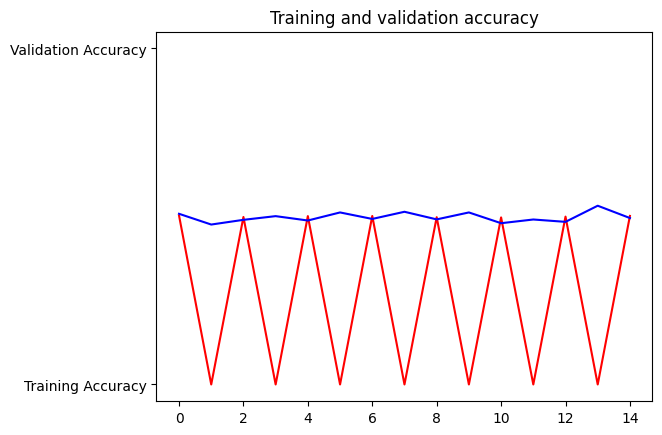

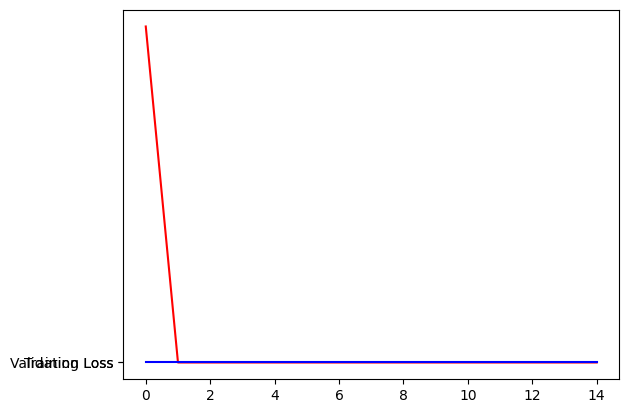

<Figure size 640x480 with 0 Axes>

In [10]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.figure()

In [11]:
import numpy as np
from google.colab import files
import keras

uploaded = files.upload()

for fn in uploaded.keys():

  # predicting images
  path = '/content/' + fn
  img = keras.preprocessing.image.load_img(path, target_size=(150, 150))
  x = keras.preprocessing.image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes[0])
  if classes[0]>0.5:
    print(fn + " is a dog")
  else:
    print(fn + " is a cat")

Saving 1_golden_retriever-35867546.jpg to 1_golden_retriever-35867546.jpg
Saving 75552.jpg to 75552.jpg
Saving images.jpg to images.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
[1.]
1_golden_retriever-35867546.jpg is a dog
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
[1.]
75552.jpg is a dog
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
[1.]
images.jpg is a dog
